# Установка библиотек

In [1]:
!pip install catboost -q

# Импорт библиотек

In [189]:
import pandas as pd
import numpy as np
from datetime import datetime

from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

# Импорт данных

In [91]:
# Данные с профилями пользователей
df = pd.read_csv('profiles.csv')
df['Session Start'] = pd.to_datetime(df['Session Start'])
df.head()

,User Id,Session Start,Session End,Device,Region,Channel,date,mean,Revenue
0,382394863972,2022-05-01 00:00:41,2022-05-01 01:13:45,Mac,Russia,MediaTornado,2022-05-01,30.482,0.0
1,428935481941,2022-05-01 00:01:35,2022-05-01 02:30:30,PC,Turkey,AdNonSense,2022-05-01,30.482,0.0
2,86266511938,2022-05-01 00:02:38,2022-05-01 01:22:33,Android,China,organic,2022-05-01,30.482,0.0
3,763000657462,2022-05-01 00:04:21,2022-05-01 00:24:15,PC,Turkey,organic,2022-05-01,30.482,0.0
4,791058813280,2022-05-01 00:05:17,2022-05-01 01:14:51,Android,Thailand,LeapBob,2022-05-01,30.482,0.0


Для сегментации пользователей будем использовать данные об их покупках

In [4]:
orders = pd.read_csv('orders.csv')
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2022-05-01 23:09:52,4.99
1,174361394180,2022-05-01 12:24:04,4.99
2,529610067795,2022-05-01 11:34:04,4.99
3,319939546352,2022-05-01 15:34:40,4.99
4,366000285810,2022-05-01 13:59:51,4.99


# 3.1 Сегментация пользователей

## Что такое RFM-анализ?
**RFM (Recency, Frequency, Monetary)** — это метод сегментации пользователей, основанный на трех показателях:

- Recency (давность) — как давно пользователь совершал покупку или был активен.
- Frequency (частота) — как часто пользователь совершает покупки.
- Monetary (стоимость) — сколько пользователь потратил за определенный период.
  
RFM помогает понять поведение клиентов и выделить ключевые группы для таргетированных действий.



## По каждому покупателю выделяем информацию для анализа

### Recency

In [5]:
# За крайнюю дату берем последнюю покупку
now = orders.sort_values('Event Dt', ascending=False).iloc[0]['Event Dt']
# Считаем, сколько прошло дней с момента покупки
recenty = orders.sort_values('Event Dt', ascending=False).drop_duplicates(subset='User Id')
recenty['recenty'] = (now - recenty['Event Dt'])\
 // np.timedelta64(1,'D')
recenty.head()

,User Id,Event Dt,Revenue,recenty
26816,271825045458,2022-10-31 23:56:56,4.99,0
38597,972738370998,2022-10-31 23:43:41,4.99,0
26860,593976069983,2022-10-31 23:32:58,4.99,0
26742,430792441847,2022-10-31 23:22:04,4.99,0
26871,143562289534,2022-10-31 23:12:19,4.99,0


### Frequency

In [6]:
frequency = orders.groupby('User Id')['Event Dt'].count().reset_index(name='frequency')
frequency.head()

,User Id,frequency
0,599326,3
1,46006712,1
2,374052872,8
3,414791703,10
4,785077127,10


### Monetary

In [7]:
monetary = orders.groupby('User Id')['Revenue'].sum().reset_index(name='monetary')
monetary.head()

,User Id,monetary
0,599326,14.97
1,46006712,4.99
2,374052872,39.92
3,414791703,49.90
4,785077127,49.90


### Объединяем данные в единую таблицу

In [8]:
rfm = recenty[['User Id', 'recenty']].merge(frequency, on='User Id').merge(monetary, on='User Id')
rfm.head()

,User Id,recenty,frequency,monetary
0,271825045458,0,2,9.98
1,972738370998,0,9,44.91
2,593976069983,0,2,9.98
3,430792441847,0,8,39.92
4,143562289534,0,5,24.95


#### Мы должны оценить каждый сегмент по трехбалльной шкале:

Давность заказа: 1 — давние, 2 — «спящие», 3 — недавние;

Частота покупок: 1 — разовые, 2 — редкие, 3 — частые;

Сумма покупок: 1 — низкий чек, 2 — средний чек, 3 — высокий чек.


**Исходя из баллов, названия сегментов такие:**
* Champion - Лучшие покупатели
* Loyal Customers - Лояльные покупатели
* Potential Loyalists - Потенциальные лояльные покупатели
* At Risk - "Спящие" покупатели, которые покупали товары
* Lost - Давние покупатели с низким чеком

In [9]:
# Присвоение оценок по квантилям
rfm['R_score'] = pd.qcut(rfm['recenty'], 3, labels=[3, 2, 1])
rfm['F_score'] = pd.cut(rfm['frequency'], 3, labels=[1, 2, 3])
rfm['M_score'] = pd.cut(rfm['monetary'], 3, labels=[1, 2, 3])

# Итоговый RFM Score
rfm['RFM_Score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1).astype(int)

# Сегментация на группы
rfm['Segment'] = rfm['RFM_Score'].apply(
    lambda x: 'Champions' if x >= 9 else
              'Loyal Customers' if x >= 7 else
              'Potential Loyalists' if x >= 5 else
              'At Risk' if x >= 4 else 'Lost'
)

In [10]:
# Распределение покупателей
rfm['Segment'].value_counts()

Segment
Potential Loyalists    2847
Lost                   2750
At Risk                2033
Loyal Customers        1004
Champions               114
Name: count, dtype: int64

### Добавляем параметр "конверсия"

In [11]:
rfm['conversion'] = (rfm['frequency'] > 1).astype('int64')

In [12]:
rfm.head()

,User Id,recenty,frequency,monetary,R_score,F_score,M_score,RFM_Score,Segment,conversion
0,271825045458,0,2,9.98,3,1,1,5,Potential Loyalists,1
1,972738370998,0,9,44.91,3,2,2,7,Loyal Customers,1
2,593976069983,0,2,9.98,3,1,1,5,Potential Loyalists,1
3,430792441847,0,8,39.92,3,2,2,7,Loyal Customers,1
4,143562289534,0,5,24.95,3,1,1,5,Potential Loyalists,1


## Проверка гипотезы различий между сегментами

In [13]:
anova_result = f_oneway(
    *[rfm.loc[rfm['Segment'] == seg, 'conversion'] for seg in rfm['Segment'].unique()]
)
print(f"ANOVA p-value: {anova_result.pvalue}")

ANOVA p-value: 0.0


#### P-value < 0.05, различия значимы. Это означает, что мы провели хорошую сегментацию, которая отлично различает пользователей между собой. Сегмент пользователя даст возможность регрессионной модели лучше предсказывать целевую переменную, что поможет в оптимизации работы приложения 

#

# 3.2 Построение регрессионной модели

In [94]:
# Добавляем сегмент в обучающий датасет
df = df.merge(rfm[['User Id', 'Segment']], on='User Id')

#### На основе проведеннного анализа и специфики задачи, могу сделать вывод, что нам необходимо модель регрессии.

### Делим выборку на обучающую и тестовую

In [151]:
# выделяем необходимые параметры
X = df.drop(['User Id', 'Session Start', 'Session End', 'date', 'mean'], axis=1)
# выделяем целевую переменую, предсказываем затраты на привлечение
y = df['mean']

# 25 процентов выборку уходит на тест модели, остальное на обучение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

In [152]:
X.head()

,Device,Region,Channel,Revenue,Segment
0,Android,Turkey,AdNonSense,9.98,Lost
1,Android,Russia,TipTop,64.87,Potential Loyalists
2,PC,Turkey,organic,39.92,Loyal Customers
3,iPhone,Russia,TipTop,59.88,Loyal Customers
4,iPhone,Russia,organic,39.92,Potential Loyalists


## Выбор алгоритма машинного обучения
### Оценивать модели будем с помощью метрики MAE. 
**MAE (Mean Absolute Error)** — это средняя абсолютная ошибка в машинном обучении. 
Она измеряет среднее абсолютное отклонение каждого прогноза от соответствующего фактического значения и показывает, насколько в среднем предсказания модели отклоняются от истинных значений.

###

**CatBoost (Categorical Boosting)** — это алгоритм машинного обучения, разработанный компанией Яндекс. Он предназначен для работы с табличными данными и особенно эффективен в задачах, где важную роль играют категориальные признаки. Основной механизм работы CatBoost — градиентный бустинг на деревьях решений.

In [159]:
# CatBoostRegressor сам преобразует категориальные признаки, поэтому сразу передаем их в модель
cat_features = ['Device', 'Region', 'Channel', 'Segment']

# Обучаем модель
model = CatBoostRegressor(cat_features=cat_features, verbose=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(f'Метрика MAE равна: {mean_absolute_percentage_error(y_test, pred):.2f}')

Метрика MAE равна: 0.26


**Линейная регрессия** — это используемая в статистике регрессионная модель зависимости одной переменной от другой или нескольких других переменных с линейной функцией зависимости.

In [160]:
# LinearRegressor не преобразует категориальные признаки, поэтому предобрабатываем данные
drop_enc = OneHotEncoder(drop='first').fit(X_train)
X_preprossess = drop_enc.transform(X_train).toarray()

# Обучаем модель
model = LinearRegression()
model.fit(X_preprossess, y_train)
pred = model.predict(drop_enc.transform(X_test).toarray())

print(f'Метрика MAE равна: {mean_absolute_percentage_error(y_test, pred):.2f}')

Метрика MAE равна: 0.26


**Случайный лес (random forest)** — это алгоритм машинного обучения, который заключается в использовании ансамбля (совокупности) деревьев решений (decision trees). Ключевая идея заключается в том, что качество классификации в случайном лесу повышается за счет большого количества ансамблей деревьев решений.

In [144]:
# RandomForestRegressor не преобразует категориальные признаки, поэтому предобрабатываем данные
drop_enc = OneHotEncoder(drop='first').fit(X_train)
X_preprossess = drop_enc.transform(X_train).toarray()

# Обучаем модель
model = RandomForestRegressor()
model.fit(X_preprossess, y_train)
pred = model.predict(drop_enc.transform(X_test).toarray())

print(f'Метрика MAE равна: {mean_absolute_percentage_error(y_test, pred):.2f}')

Метрика MAE равна: 0.27


### CatBoostRegressor и LinearRegression показали одинаковую минимальную ошибку, но берем CatBoostRegressor для дальнейшего анализа, потому что эта модель имеет больший потенциал для оптимизации, что в конечном счете даст еще лучшее качество модели

#

# 3.3 Оптимизация модели

## Преобразование набора данных

Хоть CatBoostRegressor имеет встроенную предобработку категориальных признаков, самостоятельное кодирование даст больше возможностей для преобразования набора. После кодирования будем масштабировать данные для лучшей производительности.  

### Кодирование параметров

In [161]:
# кодируем данные
cat_features = ['Device', 'Region', 'Channel', 'Segment']

drop_enc = OneHotEncoder(drop='first').fit(X[cat_features])
X_preprossess = drop_enc.transform(X[cat_features]).toarray()
X_preprossess = pd.DataFrame(X_preprossess, columns=drop_enc.get_feature_names_out())

X_cat_preprossess = pd.DataFrame(X_preprossess, columns=(list(drop_enc.get_feature_names_out())))

In [162]:
X_cat_preprossess['revenue'] = df.Revenue

### Генерация новых параметров

Для генерации возьмем параметры времени, а именно день, неделя и месяц обзвона. Это поможет предсказывать цену на привлечение, так как в прошлых модулях мы видели, что цена меняется со временем

In [163]:
X_cat_preprossess['day'] = df['Session Start'].dt.day
X_cat_preprossess['week'] = df['Session Start'].dt.isocalendar().week
X_cat_preprossess['month'] = df['Session Start'].dt.month

### Масштабирование признаков

In [164]:
scaler = StandardScaler().fit(X_cat_preprossess)
X_preprossess = scaler.transform(X_cat_preprossess)
X_preprossess = pd.DataFrame(X_preprossess, columns=X_cat_preprossess.columns)

# итоговый набор данных выглядит так
X_preprossess.head()

,Device_Mac,Device_PC,Device_iPhone,Region_Russia,Region_Thailand,Region_Turkey,Channel_FaceBoom,Channel_LeapBob,Channel_MediaTornado,Channel_OppleCreativeMedia,...,Channel_lambdaMediaAds,Channel_organic,Segment_Champions,Segment_Lost,Segment_Loyal Customers,Segment_Potential Loyalists,revenue,day,week,month
0,-0.52355,-0.458760,-0.783406,-1.856713,-0.285193,3.409307,-0.805805,-0.175019,-0.134305,-0.165419,...,-0.162478,-0.390407,-0.114907,1.476852,-0.360068,-0.694594,-0.635809,-1.645928,-1.870036,-1.540499
1,-0.52355,-0.458760,-0.783406,0.538586,-0.285193,-0.293315,-0.805805,-0.175019,-0.134305,-0.165419,...,-0.162478,-0.390407,-0.114907,-0.677116,-0.360068,1.439690,2.259041,-1.645928,-1.870036,-1.540499
2,-0.52355,2.179789,-0.783406,-1.856713,-0.285193,3.409307,-0.805805,-0.175019,-0.134305,-0.165419,...,-0.162478,2.561432,-0.114907,-0.677116,2.777255,-0.694594,0.943200,-1.645928,-1.870036,-1.540499
3,-0.52355,-0.458760,1.276478,0.538586,-0.285193,-0.293315,-0.805805,-0.175019,-0.134305,-0.165419,...,-0.162478,-0.390407,-0.114907,-0.677116,2.777255,-0.694594,1.995873,-1.645928,-1.870036,-1.540499
4,-0.52355,-0.458760,1.276478,0.538586,-0.285193,-0.293315,-0.805805,-0.175019,-0.134305,-0.165419,...,-0.162478,2.561432,-0.114907,-0.677116,-0.360068,1.439690,0.943200,-1.645928,-1.870036,-1.540499


## Оценка качества модели после преобразования данных

In [165]:
# 25 процентов выборку уходит на тест модели, остальное на обучение
X_train, X_test, y_train, y_test = train_test_split(X_preprossess, y, test_size=0.25, random_state=2)

# Обучаем модель
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(f'Метрика MAE равна: {mean_absolute_percentage_error(y_test, pred):.2f}')

Метрика MAE равна: 0.01


Вывод: мы получили отличное качество после предобработки и генерации новых признаков! 

## Оптимизация гиперпараметров

#### Подбирать гиперпараметры будем с помощью RandomizedSearchCV 

In [174]:
# гиперпараметры для подбора
params = {'learning_rate': np.arange(0.0001, 0.1, 0.0001),
         'depth': range(2, 10),
         'l2_leaf_reg': np.arange(0, 1, 0.001)}

cv = RandomizedSearchCV(CatBoostRegressor(thread_count=-1, random_state=1, verbose=0), params, n_jobs=-1, cv=5)
cv.fit(X_train, y_train)

best_params = cv.best_params_
best_params

{'learning_rate': 0.0984, 'l2_leaf_reg': 0.381, 'depth': 7}

## Оценка качества итоговой модели

In [177]:
# Обучаем модель
model = CatBoostRegressor(**best_params, verbose=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(f'Метрика MAE равна: {mean_absolute_percentage_error(y_test, pred):.4f}')

Метрика MAE равна: 0.0016


Ошибка снизилась еще больше, это отличный показатель для итоговой модели!

## Кривые валидации и обучения

In [185]:
train = model.get_evals_result()['learn']['RMSE']

Text(0, 0.5, 'Ошибка модели')

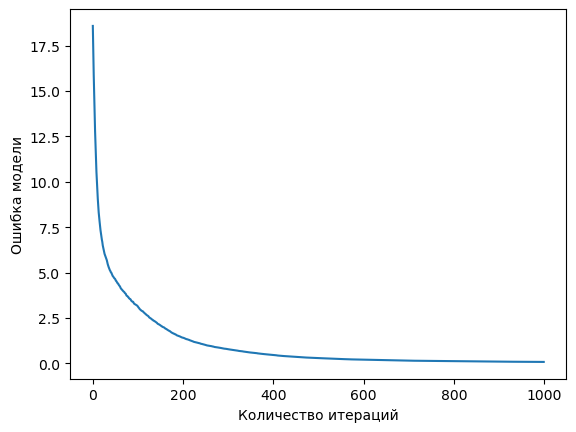

In [194]:
ax = plt.plot(train)
plt.xlabel('Количество итераций')
plt.ylabel('Ошибка модели')

### Интерпретация результатов
Из графика видно, как с ростом количества итераций уменьшается ошибка модели. Это связано с обучением модели на больших итерациях, а следовательно, улучшении модели со временем.

## Сохранение модели в файл

In [197]:
model.save_model('model.cbm')

#

# Отчет

В ходе Модуля В, были сделаны следующие действия:
* проведена сегментация пользователей
* была выбрана и построена модель регрессии
* была оптимизирована модель регрессии